In [39]:
import cv2
import numpy as np
import os
import time
import joblib
import matplotlib.pyplot as plt

from skimage.feature import hog, local_binary_pattern
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [40]:
DATASET_PATH = "dataset+detector"
MODEL_FILE = "dog_model_hog_lbp_augmented_fast.pkl"

IMG_SIZE = (128, 128)
LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS
N_SPLITS = 5

In [41]:
def extract_feature(img_bgr):
    img = cv2.resize(img_bgr, IMG_SIZE)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    hog_feat = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        feature_vector=True
    )

    lbp = local_binary_pattern(gray, LBP_POINTS, LBP_RADIUS, method="uniform")
    lbp_hist, _ = np.histogram(
        lbp.ravel(),
        bins=np.arange(0, LBP_POINTS + 3),
        range=(0, LBP_POINTS + 2)
    )
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)

    return np.hstack([hog_feat, lbp_hist])

In [42]:
def load_dataset(path):
    X, y = [], []
    print("Loading dataset with AUGMENTATION...")

    if not os.path.exists(path):
        print("Dataset path not found.")
        return np.array([]), np.array([])

    for cls in sorted(os.listdir(path)):
        folder = os.path.join(path, cls)
        
        if not os.path.isdir(folder):
            continue

        files = [f for f in os.listdir(folder) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
        print(f" - {cls}: {len(files)} original images")

        count_processed = 0
        for f in files:
            img = cv2.imread(os.path.join(folder, f))
            if img is None:
                continue
            
            X.append(extract_feature(img))
            y.append(cls)

            img_flip = cv2.flip(img, 1)
            X.append(extract_feature(img_flip))
            y.append(cls)

            rows, cols = img.shape[:2]
            M = cv2.getRotationMatrix2D((cols/2, rows/2), 15, 1)
            img_rot = cv2.warpAffine(img, M, (cols, rows))
            
            X.append(extract_feature(img_rot))
            y.append(cls)
            
            count_processed += 1

    print(f"\nTotal data after augmentation: {len(X)} samples")
    return np.array(X), np.array(y)

In [43]:
def train_and_evaluate(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

    acc_scores = []
    all_y_true = []
    all_y_pred = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X_scaled, y)):
        print(f"\nFold {fold+1}/{N_SPLITS}")

        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf = SVC(
            kernel="rbf",
            C=10,
            gamma="scale",
            class_weight="balanced",
            probability=False
        )

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        acc_scores.append(acc)
        print(f" Accuracy: {acc:.3f}")

        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)

    print("\nCross-validation Results")
    print("Mean Accuracy:", np.mean(acc_scores))

    print("\nClassification Report (All folds)")
    print(classification_report(all_y_true, all_y_pred))

    cm = confusion_matrix(all_y_true, all_y_pred)
    return scaler, clf, cm

In [44]:
def train_final_model(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    clf = SVC(
        kernel="rbf",
        C=10,
        gamma="scale",
        class_weight="balanced",
        probability=False
    )

    clf.fit(X_scaled, y)
    return scaler, clf

In [ ]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Augmented)')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def predict_with_fast_detector(image_path, model_path):
    if not os.path.exists(model_path):
        print("Model file not found! Train dulu.")
        return
        
    model_data = joblib.load(model_path)
    scaler = model_data['scaler']
    clf = model_data['svm']
    
    img = cv2.imread(image_path)
    if img is None:
        print("Image not found")
        return

    start_infer = time.time()


    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    fast = cv2.FastFeatureDetector_create(threshold=30)
    keypoints = fast.detect(gray, None)

    roi_img = img
    x, y, w, h = 0, 0, img.shape[1], img.shape[0]
    is_object_found = False

    if keypoints:
        points = np.array([kp.pt for kp in keypoints])
        
        if len(points) > 5:
            x_min, y_min = np.min(points, axis=0)
            x_max, y_max = np.max(points, axis=0)
            
            pad = 20
            x = int(max(0, x_min - pad))
            y = int(max(0, y_min - pad))
            w = int(min(img.shape[1], x_max + pad) - x)
            h = int(min(img.shape[0], y_max + pad) - y)
            
            if w > 30 and h > 30:
                roi_img = img[y:y+h, x:x+w]
                is_object_found = True

    feat = extract_feature(roi_img).reshape(1, -1)
    feat_scaled = scaler.transform(feat)
    pred = clf.predict(feat_scaled)[0]

    end_infer = time.time()

    inference_time = (end_infer - start_infer) * 1000

    print(f"Prediction result : {pred}")
    print(f"Inference time    : {inference_time:.2f} ms")

    display_img = img.copy()
    if is_object_found and pred != "non_dog": 
        cv2.rectangle(display_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        label = f"{pred} ({inference_time:.1f}ms)"
        cv2.putText(display_img, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    elif pred == "non_dog":
        label = f"NON DOG ({inference_time:.1f}ms)"
        cv2.putText(display_img, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

    img_rgb = cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(img_rgb)
    plt.title(f"Detector: FAST + Classifier: SVM\nPred: {pred}")
    plt.axis('off')
    plt.show()

Loading dataset with AUGMENTATION...
 - anjing_kampung: 14 original images
 - golden_retriever: 4 original images
 - non_dog: 20 original images
 - pom: 5 original images
 - poodle: 16 original images
 - toy_poodle: 8 original images

Total data after augmentation: 201 samples
Feature vector length: 8110

Fold 1/5
 Accuracy: 0.659

Fold 2/5
 Accuracy: 0.625

Fold 3/5
 Accuracy: 0.800

Fold 4/5
 Accuracy: 0.675

Fold 5/5
 Accuracy: 0.650

Cross-validation Results
Mean Accuracy: 0.6817073170731708

Classification Report (All folds)
                  precision    recall  f1-score   support

  anjing_kampung       0.82      0.33      0.47        42
golden_retriever       1.00      0.17      0.29        12
         non_dog       0.67      0.93      0.78        60
             pom       0.00      0.00      0.00        15
          poodle       0.66      0.85      0.75        48
      toy_poodle       0.65      1.00      0.79        24

        accuracy                           0.68       20

c:\Users\Evaldo Raynardi\anaconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Evaldo Raynardi\anaconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Evaldo Raynardi\anaconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

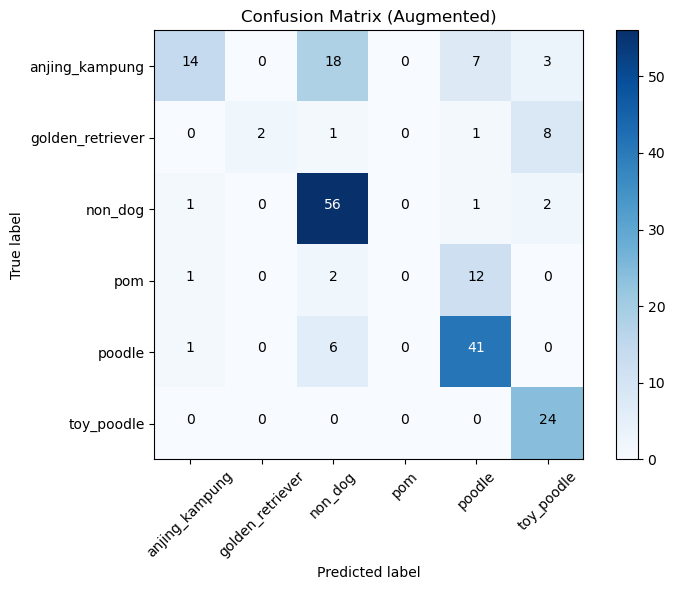


Training Final Model...

Model saved to dog_model_hog_lbp_augmented_fast.pkl
Total processing time: 13.21s

--- SIAP UNTUK TESTING ---
Gunakan fungsi: predict_with_fast_detector('path_gambar.jpg', MODEL_FILE)


In [ ]:
start = time.time()

X, y = load_dataset(DATASET_PATH)

if len(X) > 0:
    print("Feature vector length:", X.shape[1])

    scaler_cv, clf_cv, cm = train_and_evaluate(X, y)
    plot_confusion_matrix(cm, sorted(set(y)))

    print("\nTraining Final Model...")
    scaler, clf = train_final_model(X, y)

    joblib.dump({
        "svm": clf,
        "scaler": scaler,
        "classes": sorted(set(y))
    }, MODEL_FILE)

    print(f"\nModel saved to {MODEL_FILE}")
    print(f"Total processing time: {time.time()-start:.2f}s")
    
else:
    print("Dataset kosong. Pastikan folder 'dataset' terisi.")


Prediction result : poodle
Inference time    : 16.07 ms


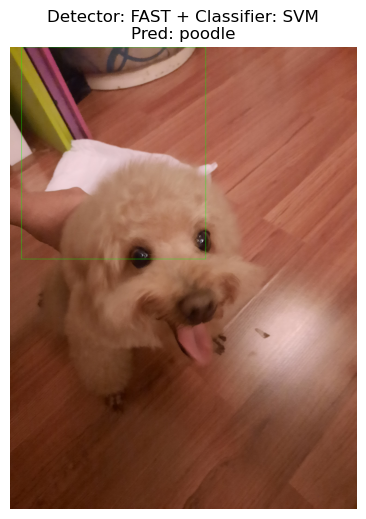

In [ ]:
# predict_with_fast_detector('./dataset+detector/non_dog/IMG_20251105_174348.jpg', MODEL_FILE)
# predict_with_fast_detector('./dataset+detector/pom/pom_1.jpg', MODEL_FILE)
# predict_with_fast_detector('./dataset+detector/anjing_kampung/anjing_kampung_1.jpg', MODEL_FILE)
# predict_with_fast_detector('./dataset+detector/golden_retriever/golden_retriever_1.jpg', MODEL_FILE)
# predict_with_fast_detector('./dataset+detector/poodle/poodle_1.jpg', MODEL_FILE)